## Final Project Submission

* Student name: Amber Yandow 
* Student pace: full time
* Scheduled project review date/time: 14 June 2019 / 1:00pm
* Instructor name: Brandon Lewis
* Blog post URL:


# Understanding the data 
 **The data set that I am using is a collection of accelerometer data taken from a smartphone that 36 individuals carried with them while conducting six different exercises including going upstairs/downstairs, jogging, sitting, standing and walking. For each exercise the acceleration for the x, y, and z axis was measured and captured with a timestamp and person ID.**

## Importing Libraries 

In [8]:
import pandas as pd 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy import stats

from sklearn.datasets import make_classification
import sklearn.linear_model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.5)



## Preparing the data 

In [9]:
# Functions for reading/importing/visualing the data 
def read_data(file_path):
    
    # Renaming the column heads
    column_names = ['user-id', 
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    
    # The 'z-axis' column has a ';' delimiter which must be removed 
    df['z-axis'].replace(regex=True, 
      inplace=True,
      to_replace=r';',
      value=r'')
    
    # Converting 'z-axis' to float after removal of ';'
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

'''I had trouble trying to load the data even after changing the z-axis column to a float.
This function solved the issue and was inspired by Nils Ackermann's tutorial on HAR datasets'''

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 


df = read_data('WISDM_ar_v1.1_raw.txt')
df.head(10)

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.055340
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.648062


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
user-id      1098203 non-null int64
activity     1098203 non-null object
timestamp    1098203 non-null int64
x-axis       1098203 non-null float64
y-axis       1098203 non-null float64
z-axis       1098203 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


### Visualizing the data 

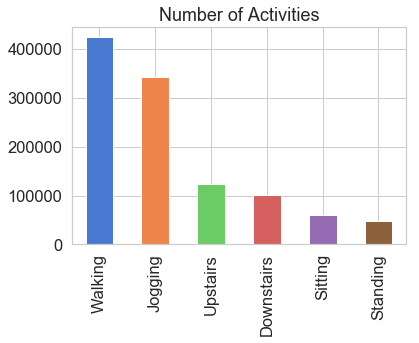

In [11]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Number of Activities')
plt.show()

In [20]:
df1 = df.groupby('activity')['user-id']
df1.head()

0         33
1         33
2         33
3         33
4         33
597       33
598       33
599       33
600       33
601       33
1161      33
1162      33
1163      33
1164      33
1165      33
1769      33
1770      33
1771      33
1772      33
1773      33
221333    27
221334    27
221335    27
221336    27
221337    27
223432    27
223433    27
223434    27
223435    27
223436    27
Name: user-id, dtype: int64

In [6]:
df[df.groupby(['activity','user-id'])]
df.head()

KeyError: <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x1a1f510a58>

In [ ]:
plt.style.use('ggplot')

def plot_activity(activity, df):
    activity_rows = (df['activity'] == activity)
    data = df[activity_rows]
    data = data[['x-axis', 'y-axis', 'z-axis']]
    data = data[:200] #limits the rows for plots 
    
    ax = data.plot(subplots=True, figsize=(15, 10), title=activity)

In [ ]:
plot_activity("Sitting", df) #add interactivity 

In [ ]:
# Transform the labels from String to Integer via LabelEncoder
activity_labels = LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df['activity_encoded'] = activity_labels.fit_transform(df['activity'].values.ravel())

In [ ]:
# Splitting for test/train
df_train = df[df['user-id'] > 28]
df_test = df[df['user-id'] <= 28]

In [ ]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operations
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 40
segments = []
labels = []
for i in range(0, len(df_train) - N_TIME_STEPS, step):
    xs = df_train['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df_train['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df_train['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df_train['activity_encoded'][i: i + N_TIME_STEPS])[0][0] #out of the 200 records the most common occuring activity gets labeled 
    segments.append([xs, ys, zs])
    labels.append(label)
    
#reshaping
x_train = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
y_train = np.asarray(labels)

In [ ]:
num_time_periods, num_sensors = x_train.shape[1],x_train.shape[2] #2 mins
num_classes = activity_labels.classes_.size

In [ ]:
x_train = x_train.reshape(x_train.shape[0], num_time_periods*num_sensors)

In [ ]:
x_train = x_train.astype('float32') #1 min
y_train = y_train.astype('float32')

In [ ]:
from sklearn.model_selection import cross_val_score #3 mins
from sklearn.neural_network import MLPClassifier

import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf


In [ ]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)

In [ ]:
model_dnn = Sequential() #1 min
model_dnn.add(Reshape((N_TIME_STEPS, 3), input_shape=(num_time_periods*num_sensors,)))
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Flatten())
model_dnn.add(Dense(num_classes, activation='softmax'))
model_dnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_dnn.summary())

In [ ]:
BATCH_SIZE = 400 #2 mins
EPOCHS = 50
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]
history = model_dnn.fit(x_train, y_train_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=callbacks_list,validation_split=0.2,verbose=1)

In [ ]:
plt.figure()
plt.plot(history.history['acc'],'r',label='Accuracy of training data')
plt.plot(history.history['val_acc'],'b',label='Accuracy of validation data')
plt.plot(history.history['loss'],'r--',label='Loss of training data')
plt.plot(history.history['val_loss'],'b--',label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.xlabel('Accuracy and Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#Normalization of test data
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [ ]:
N_TIME_STEPS = 200 #10 mins
N_FEATURES = 3
step = 40
segments = []
labels = []
for i in range(0, len(df_test) - N_TIME_STEPS, step):
    xs = df_test['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df_test['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df_test['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df_test['activity_encoded'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)
    
#reshaping
x_test = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
y_test = np.asarray(labels)

num_time_periods, num_sensors = x_test.shape[1],x_test.shape[2]
num_classes = activity_labels.classes_.size

x_test = x_test.reshape(x_test.shape[0], num_time_periods*num_sensors)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test_hot = np_utils.to_categorical(y_test, num_classes)

In [ ]:
score = model_dnn.evaluate(x_test,y_test_hot,verbose=1) # 9mins

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


In [ ]:
# LSTM Model

lstm_model = Sequential()
lstm_model.add(Embedding(20000, 128))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20, activation='softmax'))

In [ ]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()


In [ ]:
lstm_model.fit(X_t, labels, epochs=2, batch_size=32, validation_split=0.1)